In [16]:
import pandas as pd
import numpy as np
import os
import json
from hashlib import sha512
from vega3 import VegaLite
from openpyxl import load_workbook
from IPython.display import display

def display_vg(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v2+json'] = spec
    display(bundle, raw=True)
    
def mkdir(directory):
    """
    :param string directory: 
    :return: 
    """
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
def save_file(file_name, data):
    with open(file_name, "w") as f:
        f.write(data)
        

In [17]:
mkdir("../data/generated/")

In [26]:
module = 'MAT-10044'
output = {}
output["code"] = module

def get_grades(module):
    grades = pd.read_csv('../data/raw/modules/{0}/grades.csv'.format(module), skiprows=[0])
    grades = grades[['#Ass#', 'Mark', '#Cand Key']]
    grades.columns = ['ass', 'grade', 'user']
    grades['user'] = grades['user'].str.replace(r'#|/[0-9]', '').apply(lambda u: sha512(u.encode('utf-8')).hexdigest())
    grades = grades.set_index('user')

    assessments = grades['ass'].unique()
    assessment_weights = [0.8, 0.2]
    module_grades = pd.DataFrame([], index=grades.index.unique())

    for k, ass in enumerate(assessments):
        assessment_grades = grades[grades['ass'] == ass]['grade'].to_frame()
        assessment_grades.columns = [ass]
        assessment_grades['{0}_weighted'.format(ass)] = assessment_grades[ass] * assessment_weights[k]
        module_grades = module_grades.merge(assessment_grades, left_index=True, right_index=True, how="outer")

    module_grades = module_grades.fillna(0)
    module_grades['final_grade'] = module_grades.filter(regex="_weighted").sum(axis=1)
    
    return module_grades

module_grades = get_grades(module)

module_grades.head()

,#01,#01_weighted,#02,#02_weighted,final_grade
user,,,,,
0a628068de9c2a70f8685e318f5dbd07badc53704c8d7655949fda7415f195ec98c3a4d43e3957661f2fd0fce73b4814b58cf552cd35d1865cf6bf42f3e69565,96.0,76.8,89,17.8,94.6
0a6d48869596d53488f8838878198bf3caac38548d83ad7e14734297de4253f8199a814b7db1bab6091835250c7bdcc75acc14a1572f112a3967c79b1503013e,64.0,51.2,95,19.0,70.2
0a8e012a21baf4c32928caa65c149c2afd8a970a7a28820b215decefbe66778c28ae0af71c47544033919fb74846139140f9ec20dd5d8350cd3bcef2155391ff,85.0,68.0,83,16.6,84.6
18e4e11be10aaf08723ffb8f2f731ffb96d9ebdc5f38368f4b2f1e46b5f85a919d3f60d2daafcb07ead56fe24bfa63f6d13eff337a1e5f0b550c609e918bd8dc,79.0,63.2,87,17.4,80.6
1a70e13e29d382e20adf383c93d02fed2bf9b1855867b0d22415c983e81e7750f6da13abf1523d908362d4a5c8faff44b303f1c6b1572f0acf2013608633fc02,95.0,76.0,91,18.2,94.2


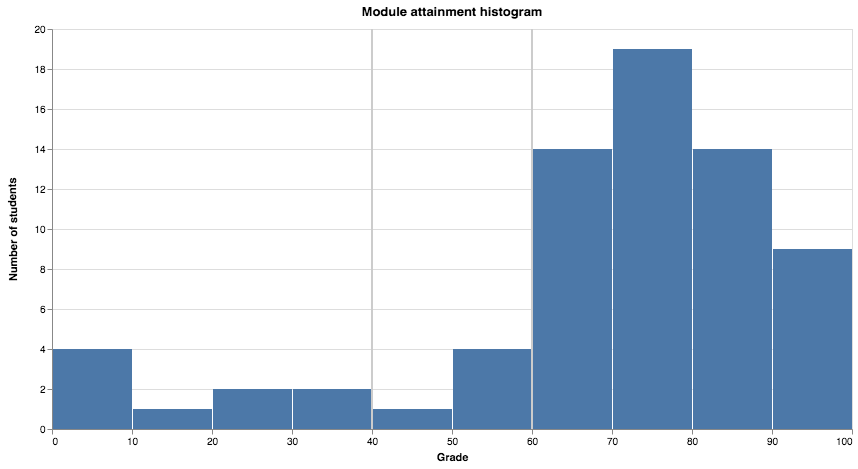

In [25]:
height = 400
width = 800

def build_grade_histogram(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module attainment histogram",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "bar",
                "encoding": {
                    "x": {
                        "bin": True,
                        "field": "final_grade",
                        "type": "quantitative",
                        "axis": {
                            "title": "Grade"
                        }
                    },
                    "y": {
                        "aggregate": "count",
                        "type": "quantitative",
                        "axis": {
                            "title": "Number of students"
                        }
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 40
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 60
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            }
        ]
    }, data)

chart = build_grade_histogram(height, width, module_grades)
output["hist"] = chart.spec

display_vg(chart.spec)

In [28]:
def get_grade_stats(grades):
    stats = {}
    stats["median"] = round(grades['final_grade'].median(), 1)
    stats["gte70"] = int(grades[grades['final_grade'] >= 70]['final_grade'].count())
    stats["gte60"] = int(grades[grades['final_grade'] >= 60]['final_grade'].count() - stats["gte70"])
    stats["lte40"] = int(grades[grades['final_grade'] <= 40]['final_grade'].count())
    stats["zeros"] = int(grades[grades['final_grade'] == 0]['final_grade'].count())

    return stats

output["stats"] = get_grade_stats(module_grades)

output["stats"]

{'gte60': 14, 'gte70': 42, 'lte40': 10, 'median': 73.8, 'zeros': 2}

In [29]:
# random average grades for now
average_grades = pd.DataFrame((np.random.random_sample(module_grades.shape[0]) * 100).round(1), columns=['average_grade'], index=module_grades.index)
compare_grades = module_grades.merge(average_grades, left_index=True, right_index=True)

compare_grades.head()

,#01,#01_weighted,#02,#02_weighted,final_grade,average_grade
user,,,,,,
0a628068de9c2a70f8685e318f5dbd07badc53704c8d7655949fda7415f195ec98c3a4d43e3957661f2fd0fce73b4814b58cf552cd35d1865cf6bf42f3e69565,96.0,76.8,89,17.8,94.6,99.2
0a6d48869596d53488f8838878198bf3caac38548d83ad7e14734297de4253f8199a814b7db1bab6091835250c7bdcc75acc14a1572f112a3967c79b1503013e,64.0,51.2,95,19.0,70.2,75.4
0a8e012a21baf4c32928caa65c149c2afd8a970a7a28820b215decefbe66778c28ae0af71c47544033919fb74846139140f9ec20dd5d8350cd3bcef2155391ff,85.0,68.0,83,16.6,84.6,61.5
18e4e11be10aaf08723ffb8f2f731ffb96d9ebdc5f38368f4b2f1e46b5f85a919d3f60d2daafcb07ead56fe24bfa63f6d13eff337a1e5f0b550c609e918bd8dc,79.0,63.2,87,17.4,80.6,82.8
1a70e13e29d382e20adf383c93d02fed2bf9b1855867b0d22415c983e81e7750f6da13abf1523d908362d4a5c8faff44b303f1c6b1572f0acf2013608633fc02,95.0,76.0,91,18.2,94.2,75.7


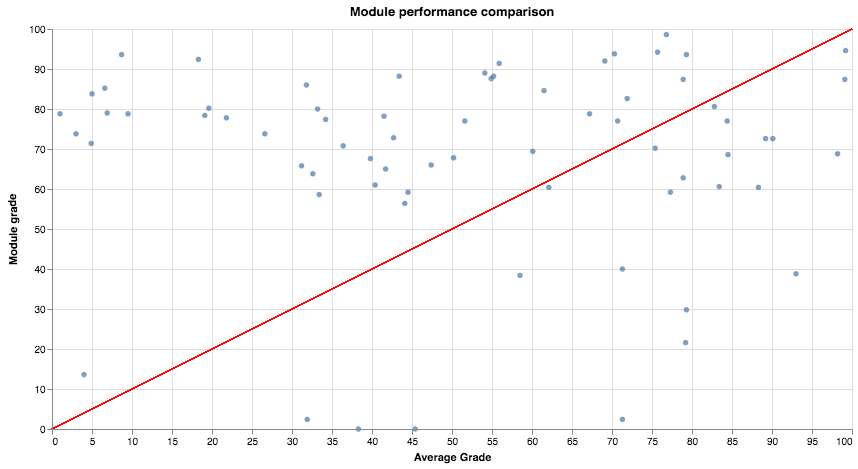

In [30]:
def build_grade_comparison_plot(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module performance comparison",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "circle",
                "encoding": {
                    "x": {
                        "field": "average_grade",
                        "type": "quantitative",
                        "axis": {
                            "title": "Average Grade"
                        }
                    },
                    "y": {
                        "field": "final_grade", 
                        "typs": "quantitative",
                        "axis": {
                            "title": "Module grade"
                        }
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": 0
                    },
                    "y": {
                        "value": height
                    },
                    "size": {
                        "value": 1
                    },
                    "color": {
                        "value": "red"
                    }
                }
            }
        ]
    }, data)
        
chart = build_grade_comparison_plot(height, width, compare_grades)
output["compare"] = chart.spec

display_vg(chart.spec)

In [34]:
questions = [
    "1. Staff are good at explaining things",
    "2. The module was well organised.",
    "3. On this module, I have received sufficient advice and support with my studies.",
    "4. The module was interesting and engaging",
    "5. Practical / tutorial / workshop sessions were helpful.",
    "6. Useful support materials were made available on the KLE",
    "7. Overall, I am satisfied with the quality of this module. ",
]
answers = [
    "Strongly Agree",
    "Agree",
    "Disagree",
    "Strongly Disagree",
    "N/A"
]

def get_student_feedback(module, questions, answers):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb_answers = pd.DataFrame(fb[questions])
    fb_answers = pd.DataFrame(fb_answers.apply(pd.value_counts))
    answers = pd.DataFrame(answers, columns=["answer"])
    answers = pd.DataFrame(answers).merge(fb_answers, left_on="answer", right_index=True, how="left").fillna(0)
    answers.columns = ["answer"] + ["q{0}".format(i+1) for i in range(len(questions))]
    
    return answers

sfb = get_student_feedback(module, questions, answers)

sfb

,answer,q1,q2,q3,q4,q5,q6,q7
0,Strongly Agree,39.0,38.0,25.0,26.0,32.0,30.0,32.0
1,Agree,17.0,18.0,30.0,27.0,19.0,23.0,23.0
2,Disagree,0.0,0.0,1.0,2.0,4.0,3.0,1.0
3,Strongly Disagree,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0


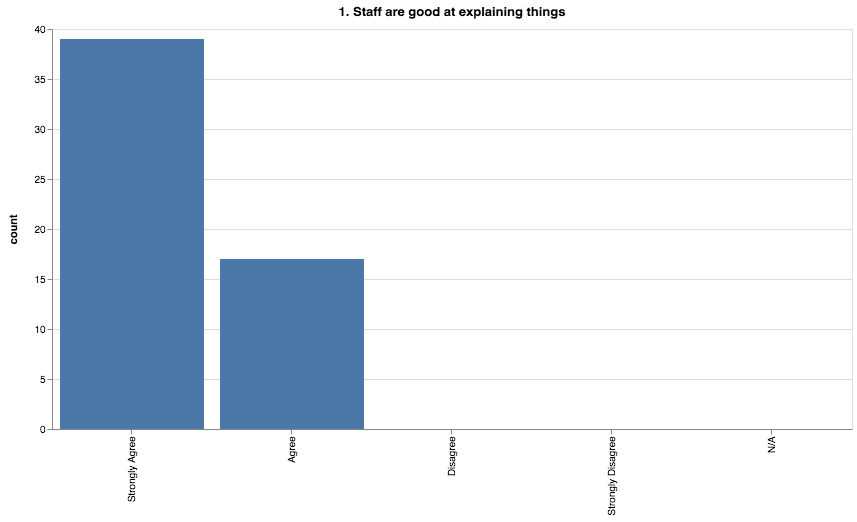

In [43]:
def build_student_feedback_histogram(height, width, data, question):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": questions[question-1],
        "height": height,
        "width": width,
        "mark": "bar",
        "encoding": {
            "x": {
                "field": "answer",
                "type": "nominal",
                "sort": None,
                "title": ""
            },
            "y": {
                "field": "q{0}".format(question),
                "type": "quantitative",
                "title": "count"
            }
        }
    }, data)

chart = build_student_feedback_histogram(height, width, sfb, 1)
output["feedback"] = chart.spec

display_vg(chart.spec)

In [10]:
# save_file("../data/generated/{0}.json".format(module), json.dumps(output))
# output